# Mount Drive & GPU Status

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! nvidia-smi

Mounted at /content/drive
Tue Nov 23 08:47:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

In [ ]:
! pip install keras_tuner

     |████████████████████████████████| 98 kB 3.4 MB/s 


# Import libraries

In [ ]:
import tensorflow
from tensorflow import keras
import keras_tuner as kt
import os
import numpy as np
# import keras
import keras.backend as K
from tensorflow.keras.layers import Input, Masking, LSTM, Dropout, Permute, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, concatenate, multiply, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.constraints import max_norm as maxnorm
import seaborn as sns
import tensorflow.keras.metrics as metrics
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Number of classes for dataset 1

In [ ]:
num_classes = 118

# Utility functions for loading datasets, plots and test performance

In [ ]:
def load_X(path):
    X_signals = []
    files = os.listdir(path)
    files.sort(key=str.lower)
    #['train_acc_x.txt', 'train_acc_y.txt', 'train_acc_z.txt', 'train_gyr_x.txt', 'train_gyr_y.txt', 'train_gyr_z.txt']
    for my_file in files:
        fileName = os.path.join(path,my_file)
        file = open(fileName, 'r')
        X_signals.append(
            [np.array(cell, dtype=np.float32) for cell in [
                row.strip().split(' ') for row in file
            ]]
        )
        file.close()
        #X_signals = 6*totalStepNum*128
    X_signals = np.transpose(np.array(X_signals), (1, 0, 2))#(totalStepNum*6*128)
    return X_signals.reshape(-1,6,128,1)#(totalStepNum*6*128*1)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    y_ = y_ - 1
    #one_hot
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [ ]:
def plot_performance(X_train, train_label):
    history = model.fit(X_train, train_label, validation_split = 0.1, epochs=100, shuffle=True, batch_size=512, callbacks=keras.callbacks.EarlyStopping(monitor='val_loss', patience=50))#, callbacks=[es_callback])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
def get_test_performance(model, X_test, test_label):
    score=model.evaluate(X_test,test_label,verbose=1)
    print(f'Test loss:{score[0]}')
    print(f'Test accuracy:{score[1]}')
    print(f'Test Recall: {score[3]}')
    print(f'Test AUC: {score[2]}')

# Squeeze Excite Block

In [ ]:
def squeeze_excite_block(tensor, ratio=16):
    init = tensor
    # channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[-1]
    se_shape = (1, filters)

    se = GlobalAveragePooling1D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    # if K.image_data_format() == 'channels_first':
    #     se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

# Dataset 1

In [ ]:
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
batch_size = 32

# optimization with keras tuner

### Model with Post-SE (Standard)

In [ ]:
def post_se(hp):
    ip = Input(shape=(6, 128))
    x = Masking()(ip)
    x = LSTM(units=hp.Choice('lstm_1', values = [8,16,32,64,128,256,512,1024,2048,4096]))(x)
    x = Dropout(hp.Choice(name='Dropout', values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(hp.Choice('conv_1_filter', values = [32,64,128,256,512,1024,2048,4096]), hp.Choice(name='conv_1_filter_stride', values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_2_filter', values = [32,64,128,256,512,1024,2048,4096]), hp.Choice(name='conv_2_filter_stride',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_3_filter', values = [32,64,128,256,512,1024,2048,4096]), hp.Choice(name='conv_3_filter_stride',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    # batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512, 1024, 2048, 4096])
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 3*1e-1, 3*1e-2, 3*1e-3, 3*1e-4, 1e-4, 1.0])), \
                  loss='categorical_crossentropy',metrics=['accuracy'])
    # model.summary()

    return model

#### post-SE Tuning

In [ ]:
class MyTuner(kt.tuners.RandomSearch):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    hp = trial.hyperparameters
    model = self.hypermodel.build(hp)
    batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512, 1024, 2048, 4096])
    # kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 30)
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

tuner = kt.tuners.RandomSearch(post_se,
    objective='val_accuracy',
    max_trials=10,
    seed=42,
    project_name='Model6')
# Will stop training if the "val_loss" hasn't improved in 3 epochs.
tuner.search(X_train, train_label, epochs=200, validation_split=0.2, shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)])

### Model with Pre-SE

In [ ]:
def pre_se(hp):
    ip = Input(shape=(6, 128))
    x = Masking()(ip)
    x = LSTM(units=hp.Choice('lstm_1', values = [8,16,32,64,128,256,512,1024,2048,4096]))(x)
    x = Dropout(hp.Choice(name='Dropout', values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))(x)
    y = Permute((2, 1))(ip)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_1_filter', values = [32,64,128,256,512,1024,2048,4096]), hp.Choice(name='conv_1_filter_stride', values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_2_filter', values = [32,64,128,256,512,1024,2048,4096]), hp.Choice(name='conv_2_filter_stride',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv1D(hp.Choice('conv_3_filter', values = [32,64,128,256,512,1024,2048,4096]), hp.Choice(name='conv_3_filter_stride',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    # batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512, 1024, 2048, 4096])
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 3*1e-1, 3*1e-2, 3*1e-3, 3*1e-4, 1e-4, 1.0])), \
                  loss='categorical_crossentropy',metrics=['accuracy'])
    # model.summary()

    return model

#### Pre-SE Tuning

In [ ]:
i = 1

In [ ]:
# class MyTuner(kt.tuners.RandomSearch):
#   def run_trial(self, trial, *args, **kwargs):
#     # You can add additional HyperParameters for preprocessing and custom training loops
#     # via overriding `run_trial`
#     hp = trial.hyperparameters
#     model = self.hypermodel.build(hp)
#     batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512, 1024, 2048, 4096])
#     # kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 30)
#     super(MyTuner, self).run_trial(trial, *args, **kwargs)


i += 1
tuner = kt.tuners.RandomSearch(pre_se,
    objective='val_accuracy',
    max_trials=10,
    seed=42,
    project_name=f'Model{i}')
# Will stop training if the "val_loss" hasn't improved in 3 epochs.
tuner.search(X_train, train_label, epochs=200, validation_split=0.2, shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)])

### Model with Identity SE

In [ ]:
def identity_se(hp):
    ip = Input(shape=(6, 128))
    x = Masking()(ip)
    x = LSTM(units=hp.Choice('lstm_1', values = [8,16,32,64,128,256,512,1024,2048,4096]))(x)
    x = Dropout(hp.Choice(name='Dropout', values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(hp.Choice('conv_1_filter', values = [32,64,128,256,512,1024,2048,4096]), hp.Choice(name='conv_1_filter_stride', values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_2_filter', values = [32,64,128,256,512,1024,2048,4096]), hp.Choice(name='conv_2_filter_stride',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_3_filter', values = [32,64,128,256,512,1024,2048,4096]), hp.Choice(name='conv_3_filter_stride',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512, 1024, 2048, 4096])
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 3*1e-1, 3*1e-2, 3*1e-3, 3*1e-4, 1e-4, 1.0])), \
                  loss='categorical_crossentropy',metrics=['accuracy'])
    # model.summary()

    return model

### Identity SE Tuning

In [ ]:
class MyTuner(kt.tuners.RandomSearch):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    hp = trial.hyperparameters
    model = self.hypermodel.build(hp)
    batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512, 1024, 2048, 4096])
    # kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 30)
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

tuner = kt.tuners.RandomSearch(identity_se,
    objective='val_accuracy',
    max_trials=10,
    seed=42,
    project_name='Model6')
# Will stop training if the "val_loss" hasn't improved in 3 epochs.
tuner.search(X_train, train_label, epochs=200, validation_split=0.2, shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)])

In [ ]:
print(dir(kt.tuners))

['BayesianOptimization', 'Hyperband', 'RandomSearch', 'Sklearn', 'SklearnTuner', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'bayesian', 'hyperband', 'randomsearch', 'sklearn_tuner']


In [ ]:
layers = ['lstm_1', 'Dropout', 'conv_1_filter', 'conv_1_filter_stride', 'conv_2_filter', 'conv_2_filter_stride', 'conv_3_filter', 'conv_3_filter_stride', 'learning_rate']
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print('Optimal Hyperparameters:')
for i in layers:
    print(f"{i}: {best_hyperparameters.get(i)}")

Optimal Hyperparameters:
lstm_1: 128
Dropout: 0.6
conv_1_filter: 512
conv_1_filter_stride: 8
conv_2_filter: 128
conv_2_filter_stride: 8
conv_3_filter: 2048
conv_3_filter_stride: 7
learning_rate: 0.01


In [ ]:
model = tensorflow.keras.models.load_model('/content/drive/Shareddrives/MMH/models/MLSTM_FCN_tuned.h5')

In [ ]:
model.summary()

# The best models start from here using PRE-SE

In [ ]:
def MLSTM_FCN(shape, num_classes):
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = LSTM(units=8)(x)
    x = Dropout(0.8)(x)
    y = Permute((2, 1))(ip)
    y = squeeze_excite_block(y)
    y = Conv1D(256, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(128, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv1D(64, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy','AUC','Recall'])
    model.summary()

    return model

In [ ]:
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 global_average_pooling1d (Glob  (None, 6)           0           ['permute[0][0]']                
 alAveragePooling1D)                                                                              
                                                                                                  
 reshape (Reshape)              (None, 1, 6)         0           ['global_average_pooling1d[0]

In [ ]:
model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)

Epoch 1/200
372/372 [==============================] - 20s 37ms/step - loss: 6.1847 - accuracy: 0.0137 - auc: 0.5428 - recall: 0.0000e+00 - val_loss: 5.9076 - val_accuracy: 0.0151 - val_auc: 0.5989 - val_recall: 0.0000e+00
Epoch 2/200
372/372 [==============================] - 10s 27ms/step - loss: 4.6459 - accuracy: 0.1086 - auc: 0.8519 - recall: 2.5231e-04 - val_loss: 4.5662 - val_accuracy: 0.0658 - val_auc: 0.8378 - val_recall: 0.0015
Epoch 3/200
372/372 [==============================] - 11s 29ms/step - loss: 3.1642 - accuracy: 0.3409 - auc: 0.9758 - recall: 0.0087 - val_loss: 2.7746 - val_accuracy: 0.3843 - val_auc: 0.9761 - val_recall: 0.0227
Epoch 4/200
372/372 [==============================] - 11s 29ms/step - loss: 2.1156 - accuracy: 0.5496 - auc: 0.9898 - recall: 0.0876 - val_loss: 2.3046 - val_accuracy: 0.4592 - val_auc: 0.9732 - val_recall: 0.1014
Epoch 5/200
372/372 [==============================] - 11s 29ms/step - loss: 1.5393 - accuracy: 0.6569 - auc: 0.9937 - recall: 0

In [ ]:
score=model.evaluate(X_test,test_label,verbose=1)
print(f'Test loss:{score[0]}')
print(f'Test accuracy:{score[1]}')
print(f'Test Recall: {score[3]}')
print(f'Test AUC: {score[2]}')

45/45 [==============================] - 1s 17ms/step - loss: 0.2693 - accuracy: 0.9390 - auc: 0.9918 - recall: 0.9304
Test loss:0.26930055022239685
Test accuracy:0.9389638304710388
Test Recall: 0.9304471015930176
Test AUC: 0.9918146133422852


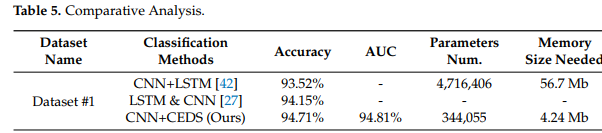

In [ ]:
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
batch_size = 32

In [ ]:
num_classes=20
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)
score=model.evaluate(X_test,test_label,verbose=1)
print(f'Test loss:{score[0]}')
print(f'Test accuracy:{score[1]}')
print(f'Test Recall: {score[3]}')
print(f'Test AUC: {score[2]}')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 128, 6)       0           ['input_2[0][0]']                
                                                                                                  
 global_average_pooling1d_3 (Gl  (None, 6)           0           ['permute_1[0][0]']              
 obalAveragePooling1D)                                                                            
                                                                                                  
 reshape_2 (Reshape)            (None, 1, 6)         0           ['global_average_pooling1d_

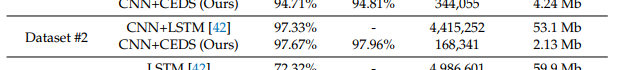

In [ ]:
# model.save('/content/drive/Shareddrives/MMH/models/MLSTM_FCN_dataset2_97_43_AUC_98_89.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
num_classes = 745
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/data')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/data')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/train_y.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/test_y.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

(13212, 6, 128, 1) (1409, 6, 128, 1)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_2 (Permute)            (None, 128, 6)       0           ['input_3[0][0]']                
                                                                                                  
 global_average_pooling1d_6 (Gl  (None, 6)           0           ['permute_2[0][0]']              
 obalAveragePooling1D)                                                                            
                                                                                                  
 reshape_4 (Reshape)            (None, 1, 6)         0 

In [ ]:
model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)
score=model.evaluate(X_test,test_label,verbose=1)
print(f'Test loss:{score[0]}')
print(f'Test accuracy:{score[1]}')
print(f'Test Recall: {score[3]}')
print(f'Test AUC: {score[2]}')

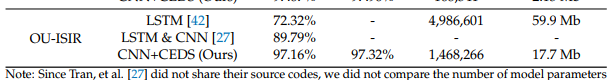

In [ ]:
get_test_performance(model, X_test, test_label)

45/45 [==============================] - 1s 14ms/step - loss: 0.1575 - accuracy: 0.9652 - auc: 0.9954 - recall: 0.9567
Test loss:0.1575421392917633
Test accuracy:0.9652235507965088
Test Recall: 0.9567068815231323
Test AUC: 0.9953792095184326
